In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, MBartForConditionalGeneration, \
    MT5ForConditionalGeneration
import os
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import paper_cka
import transformers

transformers.logging.set_verbosity_error()
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
import gc


class ClearCache:

    def __enter__(self):
        gc.collect()
        torch.cuda.empty_cache()

    def __exit__(self, exc_type, exc_val, exc_tb):
        gc.collect()
        torch.cuda.empty_cache()

In [3]:
from tqdm import tqdm
from typing import List, Union, Dict

checkpoints_dir = "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/"
directories = os.listdir(checkpoints_dir)
list_models: Dict[str, Union[MBartForConditionalGeneration, MT5ForConditionalGeneration]] = {}
print(f"Loading these models: {directories}")
for i, chckpnt in enumerate(tqdm(directories)):
    if chckpnt.startswith("checkpoint"):
        model_dir = os.path.join(checkpoints_dir, chckpnt)
        list_models[chckpnt] = AutoModelForSeq2SeqLM.from_pretrained(os.path.abspath(model_dir), output_attentions=True)
step_ft_models = list(list_models.values())

Loading these models: ['checkpoint-5000', 'checkpoint-10000', 'checkpoint-15000', 'checkpoint-20000', 'checkpoint-25000', 'checkpoint-30000', 'checkpoint-35000', 'checkpoint-40000', 'checkpoint-45000', 'checkpoint-50000', 'checkpoint-55000', 'checkpoint-60000', 'checkpoint-65000', 'checkpoint-70000', 'checkpoint-75000', 'checkpoint-80000', 'checkpoint-85000', 'checkpoint-90000', 'checkpoint-95000', 'checkpoint-100000']


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


In [4]:
from transformers import MBartConfig

tok = AutoTokenizer.from_pretrained("nikodallanoce/mbart-cc4-vanilla-32k-5", src_lang="en_XX", tgt_lang="fr_XX")
mbart_config = MBartConfig(encoder_layers=6, decoder_layers=6,
                           encoder_ffn_dim=2048, decoder_ffn_dim=2048,
                           encoder_attention_heads=8, decoder_attention_heads=8,
                           d_model=512, max_length=128, vocab_size=tok.vocab_size, dropout=0.1)
random_model: MBartForConditionalGeneration = MBartForConditionalGeneration(mbart_config)

only_ft_model: Union[
    MBartForConditionalGeneration, MT5ForConditionalGeneration] = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_ft_only/checkpoint-100000",
    output_attentions=True)

last_ft_model = list(list_models.values())[-1]

m1_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr(M1)/checkpoint-180000", output_attentions=True)
m2_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)/checkpoint-180000", output_attentions=True)
m2_model_rply = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de(M2)_replay/checkpoint-180000",
    output_attentions=True)
m3_model = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/S2_mbart_pre_en-fr_de_es(M3)/checkpoint-180000",
    output_attentions=True)
de_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_en-de/checkpoint-180000", output_attentions=True)

mf1_2_rply_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_de_ft_en-fr(Mf1-2)_replay/checkpoint-100000",
    output_attentions=True)

mf1_2_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_pre_de_ft_en-fr(Mf1-2)/checkpoint-100000",
    output_attentions=True)

mf1_model: MBartForConditionalGeneration = AutoModelForSeq2SeqLM.from_pretrained(
    "/home/n.dallanoce/PyCharm/pretraining/weights/mbart_ft_en-fr-Mf1_weights_anlsys/checkpoint-100000",
    output_attentions=True)


col_names = ['(m1, m2)', '(m2, m3)', '(m1, m3)', '(m2, de)', '(m2, rnd)']

In [6]:
from typing import List, Dict, Any

PREFIX_TASK = {'en': "English", 'fr': "French", 'de': "German", 'es': "Spanish"}


def tokenize(examples: List[Dict[str, str]], **kwargs):
    tokenizer = kwargs['tokenizer']
    src_lang: str = kwargs['lang1']
    tgt_lang: str = kwargs['lang2']
    if "task" in kwargs:
        task: str = kwargs['task']
        batch_src: List[str] = [task + e[src_lang] for e in examples]
    else:
        batch_src: List[str] = [e[src_lang] for e in examples]
    batch_tgt: List[str] = [e[tgt_lang] for e in examples]
    # tokenize the batch of sentences
    outputs = tokenizer(batch_src, text_target=batch_tgt, return_special_tokens_mask=False,
                        add_special_tokens=True, truncation=True,
                        max_length=128, padding='max_length',
                        return_attention_mask=False, return_tensors='pt')
    # labels = tokenizer(batch_tgt, truncation=False)
    # batch_tgt = tokenizer.batch_decode(labels['input_ids'], skip_special_tokens=True)

    return {'input_ids': outputs['input_ids'], 'labels': outputs['labels']}

In [7]:
from torch.utils.data import DataLoader
from datasets import Dataset


def create_dataloader(trans_pair_ds: Dataset, input_column: str, fn_kwargs: Dict[str, Any],
                      batch_size: int) -> DataLoader:
    trans_pair_ds = trans_pair_ds.map(tokenize, batched=True, input_columns=[input_column],
                                      fn_kwargs=fn_kwargs)
    # trans_pair_ds = trans_pair_ds.remove_columns(column_names=['translation', 'original_text'])
    trans_pair_ds = trans_pair_ds.with_format('torch', columns=["input_ids", "labels"], output_all_columns=False)

    # ids = [e['input_ids'].view(1, -1) for e in iter(trans_pair_ds)]
    test_loader = DataLoader(trans_pair_ds, num_workers=2, batch_size=batch_size, drop_last=True, pin_memory=False)
    return test_loader


from datasets import load_dataset
from torch.utils.data import DataLoader

wmt14_test = load_dataset("wmt14", "fr-en",
                          cache_dir="/data/n.dallanoce/wmt14",
                          split=f"test",
                          verification_mode='no_checks')

cc_test = load_dataset("yhavinga/ccmatrix", "en-fr",
                       cache_dir="/data/n.dallanoce/cc_en_fr",
                       split=f"train[0:512]",
                       verification_mode='no_checks')

wmt14_val = load_dataset("wmt14", "fr-en",
                         cache_dir="/data/n.dallanoce/wmt14",
                         split=f"validation[0:256]",
                         verification_mode='no_checks')

fn_kwargs = {'tokenizer': tok, 'lang1': "en", 'lang2': "fr"}
dataloader_test = create_dataloader(wmt14_test, "translation", fn_kwargs, 32)
dataloader_val = create_dataloader(wmt14_val, "translation", fn_kwargs, 32)
dataloader_cc = create_dataloader(cc_test, "translation", fn_kwargs, 32)

<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileInfo size changed, may indicate binary incompatibility. Expected 64 from C header, got 88 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: pyarrow._fs.FileSelector size changed, may indicate binary incompatibility. Expected 48 from C header, got 72 from PyObject
Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Found cached dataset ccmatrix (/data/n.dallanoce/cc_en_fr/yhavinga___ccmatrix/en-fr/1.0.0/5f733aeea277b2b1bb792442ba120c0f7f4b1c7288897051bdf1e9865fe77b93)
Found cached dataset wmt14 (/data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4)
Loading cached processed dataset at /data/n.dallanoce/wmt14/wmt14/fr-en/1.0.0/2de185b074515e97618524d69f5e27ee7545dcbed4aa9bc1a4235710ffca33f4/cache-8fc61ae01fc78967.arrow
Loading cached processed dataset at /data/n.dallanoce/

/home/n.dallanoce/PyCharm/pretraining/paper_cka/cka.py:139: UserWarning: Dataloader for Model 2 is not given. Using the same dataloader for both models.
  warn("Dataloader for Model 2 is not given. Using the same dataloader for both models.")
| Comparing features |: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]


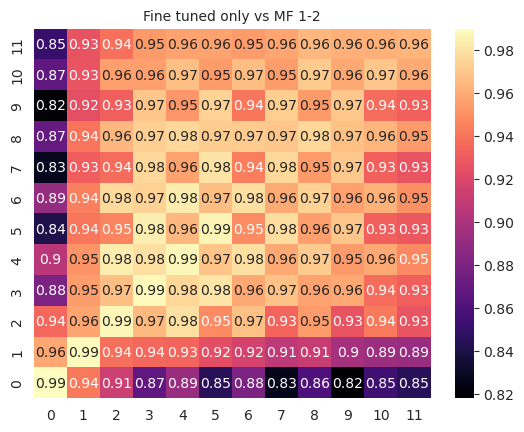

| Comparing features |: 100%|██████████| 8/8 [00:28<00:00,  3.61s/it]


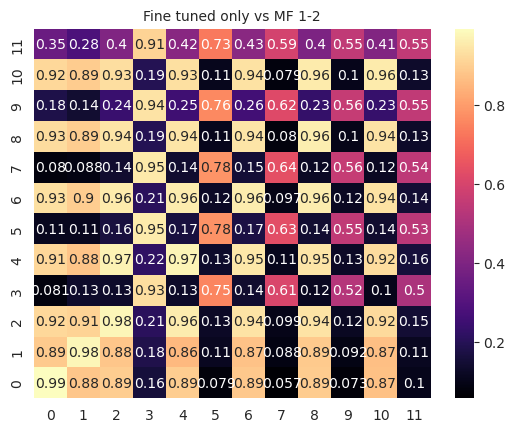

In [8]:
layers_norm = [f"model.encoder.layers.{i}.self_attn_layer_norm" for i in range(6)] + [
    f"model.encoder.layers.{i}.final_layer_norm" for i in range(6)]
layers_fc = [f"model.encoder.layers.{i}.fc1" for i in range(6)] + [f"model.encoder.layers.{i}.fc2" for i in range(6)]
#layers = [f"model.encoder.layers.{i}.self_attn.out_proj" for i in range(6)]
for l_t in [layers_norm, layers_fc]:
    with ClearCache():
        with torch.no_grad():
            cka = paper_cka.CKA(last_ft_model, mf1_2_model, "Fine tuned only", "MF 1-2", model1_layers = l_t,
            model2_layers = l_t, device = "cuda:0")
            cka.compare(dataloader_val, debiased=True)
            #print(cka.sanity_check())
            cka.plot_results()
#print(cka.model1_info['Layers'])
#print(cka.export()["CKA"])
#print(m1_model)

In [6]:
all_lyrs = list(last_ft_model.named_modules())
all_lyrs

[('',
  MBartForConditionalGeneration(
    (model): MBartModel(
      (shared): Embedding(32030, 512, padding_idx=1)
      (encoder): MBartEncoder(
        (embed_tokens): Embedding(32030, 512, padding_idx=1)
        (embed_positions): MBartLearnedPositionalEmbedding(1026, 512)
        (layers): ModuleList(
          (0): MBartEncoderLayer(
            (self_attn): MBartAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          

In [ ]:
activation = []


def get_activation(name):
    def hook(model, input, output):
        with torch.no_grad():
            activation.append(output)

    return hook


dev = "cpu"
model = last_ft_model.to(dev)
model.model.encoder.layers[0].self_attn.register_forward_hook(get_activation('a'))

In [ ]:
dev = "cpu"
model = last_ft_model.to(dev)
for e in dataloader_test:
    out = last_ft_model(e['input_ids'].to(dev))
    break

In [ ]:
activation[0][0].shape